## Preparation

In [1]:
!pip install -q opencv-python
!pip install tensorflow_hub

In [2]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os

import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Code to run pose estimation using MoveNet

In [3]:
print(os.getcwd())
print(os.path.abspath(r'examples/lite/examples/pose_estimation/raspberry_pi'))

/home/jovyan/work/pose-monitor/main
/home/jovyan/work/pose-monitor/main/examples/lite/examples/pose_estimation/raspberry_pi


In [4]:
# Download model from TF Hub and check out inference code from GitHub
# !wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
# !git clone https://github.com/tensorflow/examples.git

pose_sample_rpi_path = r'examples/lite/examples/pose_estimation/raspberry_pi'

sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

In [5]:
#@title Functions to visualize the pose estimation results.

def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.
 
  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.
 
  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [6]:
# Code to load the images, detect pose landmarks and save them into a CSV file

class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""
 
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    """Creates a preprocessor to detection pose from images and save as CSV.

    Args:
      images_in_folder: Path to the folder with the input images. It should
        follow this structure:
        yoga_poses
        |__ downdog
            |______ 00000128.jpg
            |______ 00000181.bmp
            |______ ...
        |__ goddess
            |______ 00000243.jpg
            |______ 00000306.jpg
            |______ ...
        ...
      images_out_folder: Path to write the images overlay with detected
        landmarks. These images are useful when you need to debug accuracy
        issues.
      csvs_out_path: Path to write the CSV containing the detected landmark
        coordinates and label of each image that can be used to train a pose
        classification model.
    """
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: Number of images to load. As preprocessing usually
        takes time, this parameter can be specified to make the reduce of the
        dataset for testing.
      detection_threshold: Only keep images with all landmark confidence score
        above this threshold.
    """
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

In [7]:
pwd

'/home/jovyan/work/pose-monitor/main'

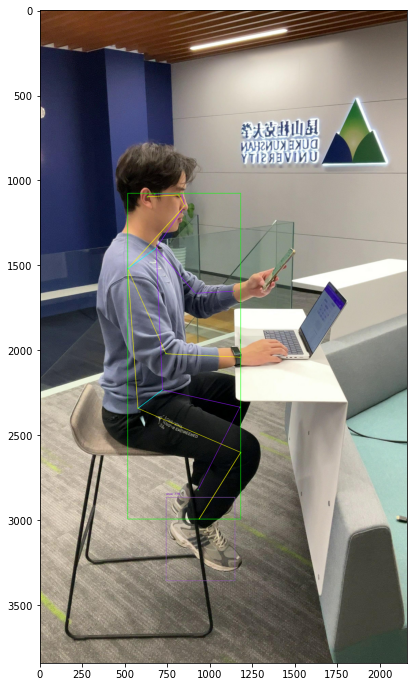

In [8]:
image_bad = tf.io.read_file('/home/jovyan/work/pose-monitor/shoe_detect/109_flip.jpg')
image_bad = tf.io.decode_jpeg(image_bad)
person = detect(image_bad)
_ = draw_prediction_on_image(image_bad.numpy(), person, crop_region=None, 
                           close_figure=False, keep_input_size=True)

In [9]:
person.keypoints

[KeyPoint(body_part=<BodyPart.NOSE: 0>, coordinate=Point(x=851, y=1150), score=0.52681464),
 KeyPoint(body_part=<BodyPart.LEFT_EYE: 1>, coordinate=Point(x=833, y=1077), score=0.46607542),
 KeyPoint(body_part=<BodyPart.RIGHT_EYE: 2>, coordinate=Point(x=816, y=1087), score=0.5960989),
 KeyPoint(body_part=<BodyPart.LEFT_EAR: 3>, coordinate=Point(x=676, y=1082), score=0.28790298),
 KeyPoint(body_part=<BodyPart.RIGHT_EAR: 4>, coordinate=Point(x=633, y=1098), score=0.75351846),
 KeyPoint(body_part=<BodyPart.LEFT_SHOULDER: 5>, coordinate=Point(x=683, y=1399), score=0.455311),
 KeyPoint(body_part=<BodyPart.RIGHT_SHOULDER: 6>, coordinate=Point(x=516, y=1522), score=0.5899955),
 KeyPoint(body_part=<BodyPart.LEFT_ELBOW: 7>, coordinate=Point(x=913, y=1665), score=0.474417),
 KeyPoint(body_part=<BodyPart.RIGHT_ELBOW: 8>, coordinate=Point(x=741, y=2021), score=0.37778774),
 KeyPoint(body_part=<BodyPart.LEFT_WRIST: 9>, coordinate=Point(x=1144, y=1653), score=0.52672905),
 KeyPoint(body_part=<BodyPart

## Part 1: Preprocess the input images

In [10]:
use_custom_dataset = True #@param ["False", "True"] {type:"raw"}

dataset_is_split = False #@param ["False", "True"] {type:"raw"}

In [11]:
#@markdown Be sure you run this cell. It's hiding the `split_into_train_test()` function that's called in the next code block.

import os
import random
import shutil

def split_into_train_test(images_origin, images_dest, test_split):
  _, dirs, _ = next(os.walk(images_origin))

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  for dir in dirs:
    # Get all filenames for this dir, filtered by filetype
    filenames = os.listdir(os.path.join(images_origin, dir))
    filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp') or f.endswith('.JPG'))]
    # Shuffle the files, deterministically
    filenames.sort()
    random.seed(7)
    random.shuffle(filenames)
    # Divide them into train/test dirs
    os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
    test_count = int(len(filenames) * test_split)
    for i, file in enumerate(filenames):
      if i < test_count:
        destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
      else:
        destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
      shutil.copyfile(file, destination)
    print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')
  print(f'Your split dataset is in "{images_dest}"')

In [12]:
## set the dataset_in as your own path
#Split the data into train and test
# if use_custom_dataset:
#     dataset_in = 'sitdata'

#   # You can leave the rest alone:
#     if not os.path.isdir(dataset_in):
#         raise Exception("dataset_in is not a valid directory")
#     if dataset_is_split:
#         IMAGES_ROOT = dataset_in
#     else:
#         dataset_out = 'split_' + dataset_in
#         split_into_train_test(dataset_in, dataset_out, test_split=0.3)
#         IMAGES_ROOT = dataset_out

**Note:** If you're using `split_into_train_test()` to split the dataset, it expects all images to be PNG, JPEG, or BMP—it ignores other file types.

### Preprocess the `TRAIN` dataset

In [13]:
#os.listdir('/home/jovyan/work/pose-monitor/main/split_sitdata/train/normal')

In [14]:
#Uncomment this cell if you need split train data

# import os
# import shutil

# train_list = os.listdir('/home/jovyan/work/pose-monitor/main/split_sitdata/train/head-forward')

# for i in range(400): 
#     a = "/home/jovyan/work/pose-monitor/main/split_sitdata/train/head-forward/"+train_list[i]
#     shutil.move(a, '/home/jovyan/work/pose-monitor/main/split_sitdata/train1/head-forward') 
#len(os.listdir('/home/jovyan/work/pose-monitor/main/split_sitdata/train1/head-forward'))

In [15]:
#comment below if you directly use the tran_data.csv file

# images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
# images_out_train_folder = 'poses_images_out_train'
# csvs_out_train_path = 'train_data.csv'

# preprocessor = MoveNetPreprocessor(
#   images_in_folder=images_in_train_folder,
#   images_out_folder=images_out_train_folder,
#   csvs_out_path=csvs_out_train_path,
# )

# preprocessor.process(per_pose_class_limit=None)

In [16]:
#comment below if you directly use the test_data.csv file

# images_in_train_folder = os.path.join(IMAGES_ROOT, 'train1')
# images_out_train_folder = 'poses_images_out_train'
# csvs_out_train_path = 'train_data1.csv'

# preprocessor = MoveNetPreprocessor(
#   images_in_folder=images_in_train_folder,
#   images_out_folder=images_out_train_folder,
#   csvs_out_path=csvs_out_train_path,
# )

# preprocessor.process(per_pose_class_limit=None)

### Preprocess the `TEST` dataset

In [17]:
# images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
# images_out_test_folder = 'poses_images_out_test'
# csvs_out_test_path = 'test_data.csv'

# preprocessor = MoveNetPreprocessor(
#   images_in_folder=images_in_test_folder,
#   images_out_folder=images_out_test_folder,
#   csvs_out_path=csvs_out_test_path,
# )

# preprocessor.process(per_pose_class_limit=None)

## Part 2: Train a pose classification model that takes the landmark coordinates as input, and output the predicted labels.

### Load the preprocessed CSVs into `TRAIN` and `TEST` datasets.

In [19]:
data1 = pd.read_csv('train_data.csv')
data2 = pd.read_csv('train_data1.csv')
data = pd.concat([data1, data2],axis=0)

In [20]:
import pandas as pd
import random
from sklearn.utils import shuffle
data = shuffle(data) 
data.to_csv('train_data_new.csv',index=0)
data1 = pd.read_csv('test_data.csv')
data1 = shuffle(data1) 
data1.to_csv('test_data_new.csv',index=0)

In [21]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

Load and split the original `TRAIN` dataset into `TRAIN` (85% of the data) and `VALIDATE` (the remaining 15%).

In [22]:
csvs_out_train_path = 'train_data_new.csv'
csvs_out_test_path = 'test_data_new.csv'
is_skipped_step_1 = True

# Load the train data
X_train, y_train, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
# X_train, X_val, y_train, y_val = train_test_split(X, y,
#                                                   test_size=0.15)

In [23]:
X_train[:5]

,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,LEFT_EAR_x,...,LEFT_KNEE_score,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_score,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_score,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_score
0,796.0,1132.0,0.627258,768.0,1060.0,0.748389,739.0,1069.0,0.616102,601.0,...,0.605684,1035.0,2393.0,0.761421,929.0,2867.0,0.134327,919.0,2952.0,0.592815
1,456.0,1586.0,0.787745,447.0,1536.0,0.520659,393.0,1548.0,0.778481,357.0,...,0.613852,990.0,2152.0,0.571703,1412.0,2887.0,0.553153,1412.0,2878.0,0.408772
2,971.0,1464.0,0.659375,965.0,1405.0,0.423632,956.0,1412.0,0.501956,807.0,...,0.375072,911.0,2160.0,0.223762,791.0,2302.0,0.183306,958.0,2719.0,0.624595
3,638.0,1040.0,0.639108,614.0,981.0,0.425808,584.0,990.0,0.443254,445.0,...,0.225366,1157.0,2308.0,0.740464,962.0,2866.0,0.254963,978.0,2904.0,0.413999
4,766.0,1208.0,0.516873,757.0,1142.0,0.482979,723.0,1154.0,0.399059,582.0,...,0.370201,1171.0,2475.0,0.539679,803.0,2766.0,0.422006,853.0,2942.0,0.426196


In [24]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

In [25]:
X_test[:5]

,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,LEFT_EAR_x,...,LEFT_KNEE_score,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_score,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_score,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_score
0,1256.0,1755.0,0.529919,1257.0,1699.0,0.460196,1224.0,1711.0,0.683122,1125.0,...,0.159648,942.0,2487.0,0.649847,1126.0,2627.0,0.622147,989.0,3030.0,0.679924
1,965.0,1088.0,0.543714,944.0,1008.0,0.551931,933.0,1017.0,0.619819,747.0,...,0.249966,1281.0,2707.0,0.421999,832.0,2985.0,0.287560,814.0,3166.0,0.634856
2,831.0,1033.0,0.381799,793.0,948.0,0.587357,794.0,954.0,0.496048,588.0,...,0.152153,1324.0,2563.0,0.339300,856.0,2771.0,0.161379,880.0,3010.0,0.277155
3,1169.0,1358.0,0.536567,1176.0,1292.0,0.192618,1161.0,1299.0,0.414098,1006.0,...,0.190517,1162.0,2474.0,0.714370,877.0,2822.0,0.270946,907.0,2912.0,0.503850
4,1431.0,1326.0,0.470601,1395.0,1252.0,0.379321,1407.0,1279.0,0.596912,1139.0,...,0.368572,1365.0,2629.0,0.494339,841.0,2897.0,0.215090,844.0,3029.0,0.362250


### Define functions to convert the pose landmarks to a pose embedding (a.k.a. feature vector) for pose classification

Next, convert the landmark coordinates to a feature vector by:
1. Moving the pose center to the origin.
2. Scaling the pose so that the pose size becomes 1
3. Flattening these coordinates into a feature vector

Then use this feature vector to train a neural-network based pose classifier.

In [26]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

### Define a Keras model for pose classification

Our Keras model takes the detected pose landmarks, then calculates the pose embedding and predicts the pose class.

In [27]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 51)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 17, 3)        0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 17, 2)        0           reshape[0][0]                    
__________________________________________________________________________________________________
tf.compat.v1.gather (TFOpLambda (None, 2)            0           tf.__operators__.getitem[0][0]   
______________________________________________________________________________________________

In [28]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
161/161 [==============================] - 9s 28ms/step - loss: 1.0064 - accuracy: 0.5363 - val_loss: 0.8005 - val_accuracy: 0.6632

Epoch 00001: val_accuracy improved from -inf to 0.66323, saving model to weights.best.hdf5
Epoch 2/200
161/161 [==============================] - 4s 27ms/step - loss: 0.6840 - accuracy: 0.7102 - val_loss: 0.4709 - val_accuracy: 0.8898

Epoch 00002: val_accuracy improved from 0.66323 to 0.88976, saving model to weights.best.hdf5
Epoch 3/200
161/161 [==============================] - 5s 33ms/step - loss: 0.4752 - accuracy: 0.8323 - val_loss: 0.2991 - val_accuracy: 0.9485

Epoch 00003: val_accuracy improved from 0.88976 to 0.94852, saving model to weights.best.hdf5
Epoch 4/200
161/161 [==============================] - 4s 28ms/step - loss: 0.3367 - accuracy: 0.8881 - val_loss: 0.2131 - val_accuracy: 0.9522

Epoch 00004: val_accuracy improved from 0.94852 to 0.95215, saving model to weights.best.hdf5
Epoch 5/200
161/161 [==========================

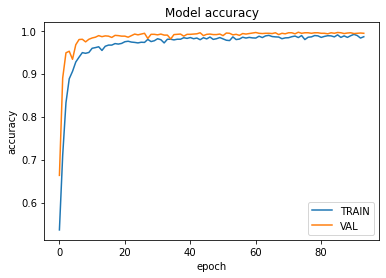

In [29]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [30]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

52/52 [==============================] - 1s 11ms/step - loss: 0.1761 - accuracy: 0.9297


### Draw the confusion matrix to better understand the model performance

Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

   cross-leg       1.00      0.92      0.96       544
head-forward       1.00      0.85      0.92       489
      normal       0.84      1.00      0.91       618

    accuracy                           0.93      1651
   macro avg       0.95      0.92      0.93      1651
weighted avg       0.94      0.93      0.93      1651



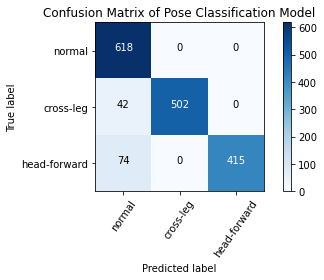

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

### Convert the pose classification model to TensorFlow Lite

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpj7lvk9lk/assets
Model size: 26KB


Then you'll write the label file which contains mapping from the class indexes to the human readable class names.

In [33]:
with open('pose_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

As you've applied quantization to reduce the model size, let's evaluate the quantized TFLite model to check whether the accuracy drop is acceptable.

In [34]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

In [35]:
# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.856450635978195


Now you can download the TFLite model (`pose_classifier.tflite`) and the label file (`pose_labels.txt`) to classify custom poses. See the [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/android) and [Python/Raspberry Pi](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/raspberry_pi) sample app for an end-to-end example of how to use the TFLite pose classification model.

## Part 3: Train incremental classification models based on previous baseline classifier

### A Classifier with Object Detection

In [36]:
import tensorflow as tf
from PIL import Image
import csv
import codecs
#start to load the tflite to predict a image
def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image

def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
 
  signature_fn = interpreter.get_signature_runner()
  # Feed the input image to the model
  output = signature_fn(images=image)
  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])
 
  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results

def get_shoe(filename,i):
    classes = ['shoe']
    DETECTION_THRESHOLD = 0.3
    #  modify this path as your own path
    model_path = '/home/jovyan/work/pose-monitor/shoe_detect/tensorflow/training_demo/models/detectMode/model.tflite'
    TEMP_FILE = '/home/jovyan/work/pose-monitor/main/sitdata/'+filename

    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
      # Load the input image and preprocess it
    preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )
 
    results = detect_objects(interpreter, preprocessed_image, DETECTION_THRESHOLD)
    
    print('Task %d done' %(i))
    return results


def data_write_csv(file_name, datas):
        file_csv = codecs.open(file_name,'w+','utf-8')
        writer = csv.writer(file_csv, delimiter=' ', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        for data in datas:
            writer.writerow(data)
        print("Save_Done")


In [37]:
# res = []
# for file in ["1067_flip.jpg","109_flip.jpg","1124_flip.jpg","1155_flip.jpg","1253_flip.jpg","1415_flip.jpg","1419_flip.jpg","1426_flip.jpg","1483_flip.jpg"]:
#     classes = ['shoe']
#     DETECTION_THRESHOLD = 0.3
#     # modify this path to where you store the shoe_detect file
#     model_path = '/home/jovyan/work/pose-monitor/shoe_detect/tensorflow/training_demo/models/detectMode/model.tflite'
#     TEMP_FILE = '/home/jovyan/work/pose-monitor/shoe_detect/tensorflow/training_demo/images/test/'+file

#     # Load the TFLite model
#     interpreter = tf.lite.Interpreter(model_path=model_path)
#     interpreter.allocate_tensors()

#     results = detect_objects(interpreter, preprocessed_image, DETECTION_THRESHOLD)
#     res.append(results)

In [38]:
# comment below codes if you use the train_boxes.npy

train_data = pd.read_csv("train_data_new.csv")
# train_boxes = []
# for i in range(len(train_data)):
#     box_result = get_shoe(train_data["file_name"][i],i)
#     train_boxes.append(box_result)
# data_write_csv('/home/jovyan/work/pose-monitor/main/train_boxes.csv', train_boxes)
# np.save('train_boxes.npy',boxes)

In [39]:
# comment below codes if you use the test_boxes.npy

test_data = pd.read_csv("test_data_new.csv")
# test_boxes = []
# for i in range(len(test_data)):
#     box_result = get_shoe(test_data["file_name"][i],i)
#     test_boxes.append(box_result)
# data_write_csv('/home/jovyan/work/pose-monitor/main/test_boxes.csv', test_boxes)
# np.save('test_boxes.npy',test_boxes)

In [40]:
# load the pre_trained data
train_box = np.load('train_boxes.npy',allow_pickle=True)
test_box = np.load('test_boxes.npy',allow_pickle=True)

In [41]:
def get_twobox(results):
    two_box = []   
    ymid1 = (results[0]['bounding_box'][0]+results[0]['bounding_box'][2])/2
    xmid1 = (results[0]['bounding_box'][1]+results[0]['bounding_box'][3])/2
    score1 = results[0]['score']

    ymid2 = (results[1]['bounding_box'][0]+results[1]['bounding_box'][2])/2
    xmid2 = (results[1]['bounding_box'][1]+results[1]['bounding_box'][3])/2
    score2 = results[1]['score']

    two_box.append([ymid1,xmid1,score1,ymid2,xmid2,score2])
    return two_box
    # pd.DataFrame(two_box)

In [42]:
#reset columns name
columns = ["ymid1","xmid1","score1","ymid2","xmid2","score2"]

train_res=[]
for i in range(len(train_box)):
    cur = get_twobox(train_box[i])
    train_res.append(cur[0])
train_boxdf = pd.DataFrame(train_res)
train_boxdf.columns = columns

test_res=[]
for i in range(len(test_box)):
    cur = get_twobox(test_box[i])
    test_res.append(cur[0])
test_boxdf = pd.DataFrame(test_res)
test_boxdf.columns = columns

In [43]:
train_with_box = pd.concat([X_train,train_boxdf],axis = 1)
test_with_box = pd.concat([X_test,test_boxdf],axis = 1)

In [44]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (19*2), 19, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (19*2), 19, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((19, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [45]:
# Define the model
inputs = tf.keras.Input(shape=(57))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model4 = keras.Model(inputs, outputs)
model4.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 19, 3)        0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 19, 2)        0           reshape_1[0][0]                  
__________________________________________________________________________________________________
tf.compat.v1.gather_9 (TFOpLamb (None, 2)            0           tf.__operators__.getitem_1[0][0] 
____________________________________________________________________________________________

In [46]:
model4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model4.fit(train_with_box, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(test_with_box, y_test),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
161/161 [==============================] - 5s 28ms/step - loss: 1.0392 - accuracy: 0.4902 - val_loss: 0.8997 - val_accuracy: 0.7765

Epoch 00001: val_accuracy improved from -inf to 0.77650, saving model to weights.best.hdf5
Epoch 2/200
161/161 [==============================] - 5s 28ms/step - loss: 0.7704 - accuracy: 0.6810 - val_loss: 0.5409 - val_accuracy: 0.9237

Epoch 00002: val_accuracy improved from 0.77650 to 0.92368, saving model to weights.best.hdf5
Epoch 3/200
161/161 [==============================] - 5s 29ms/step - loss: 0.5298 - accuracy: 0.7984 - val_loss: 0.3476 - val_accuracy: 0.9249

Epoch 00003: val_accuracy improved from 0.92368 to 0.92489, saving model to weights.best.hdf5
Epoch 4/200
161/161 [==============================] - 4s 27ms/step - loss: 0.3764 - accuracy: 0.8771 - val_loss: 0.2359 - val_accuracy: 0.9243

Epoch 00004: val_accuracy did not improve from 0.92489
Epoch 5/200
161/161 [==============================] - 4s 27ms/step - loss: 0.3010 - a

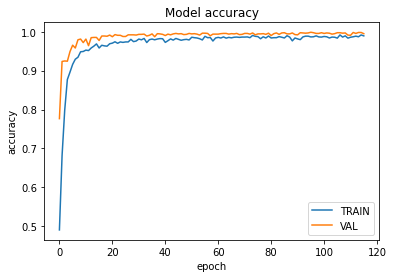

In [47]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [48]:
# Evaluate the model using the TEST dataset
loss, accuracy = model4.evaluate(test_with_box, y_test)

52/52 [==============================] - 1s 19ms/step - loss: 0.0414 - accuracy: 0.9861


Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

   cross-leg       1.00      0.99      0.99       544
head-forward       0.99      0.97      0.98       489
      normal       0.97      1.00      0.98       618

    accuracy                           0.99      1651
   macro avg       0.99      0.98      0.99      1651
weighted avg       0.99      0.99      0.99      1651



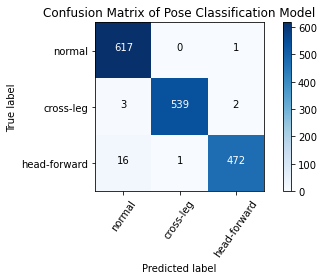

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model4.predict(test_with_box)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))